<a href="https://colab.research.google.com/github/KozinIS/CV/blob/main/07_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0_(CNN_U_Net).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Сегментация текста (CNN U-Net)**



# 1 Постановка задачи

*Подготовьте свёрточную нейронную сеть, предназначенную для сегментации договоров и добейтесь точности 70% по среднему показателю распознавания или 0.45 для val_dice_coef.*

# 2 Подгрузка библиотек и подключение диска

In [ ]:
!pip install pymorphy2 # установка лемматизатора pymorphy2

     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 8.2MB 12.6MB/s 


In [ ]:
import numpy as np # Библиотека для работы с массивами данных
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import word2vec # Импортируем gensim
import os # Импортируем для работы с файловой системой
import pymorphy2 # Импортируем для работы с леммами
import time # Импортируем для подсчета времени
import seaborn as sns
sns.set_style('darkgrid')

from tensorflow.keras.models import Model, load_model # Импортируем модель, метод загрузки предобученной сети
import re # Импортируем для работы со строками
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
# Импортируем слои для сеток
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation, MaxPooling1D, Conv1D, BatchNormalization, Dropout, Conv2DTranspose, Lambda
from tensorflow.keras import backend as K # Импортируем для подсчета dice_coef
from tensorflow.keras.optimizers import Adam, Adadelta # Импортируем оптимизаторы
from tensorflow.keras import utils # Импортируем для работы с категориальными данными
from google.colab import files # Импортируем для работы с файлами

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3 Функция работы с текстом

In [ ]:
# Чтение файла текста из файла, очитска от знаков препинания
def readText(fileName):
  f = open(fileName, 'r') #Открываем наш файл для чтения и считываем из него данные
  text = f.read() #Записываем прочитанный текст в переменную
  # Определяем символы для удаления
  delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";"]

  for dS in delSymbols: # Каждый символ в списке символов для удаления
    text = text.replace(dS, " ") # Удаляем, заменяя на пробел

  # Ищем шаблоны и символы в строке и меняем на указанную подстроку
  text = re.sub("[.]", " ", text)
  text = re.sub(":", " ", text)
  text = re.sub("<", " <", text)
  text = re.sub(">", "> ", text)

  # Метод split разделит текст по пробелам (а их может быть несколько после удаления символов)
  # При помощи метода join запишем все разделенные слова снова в строку
  text = ' '.join(text.split())

  text = text.lower() # Переводим текст в нижний регистр
  return text # Возвращаем тексты

# Преобразование исходного текста в список из слов в нормальной форме
def text2Words(text):
  morph = pymorphy2.MorphAnalyzer() # Создаем экземпляр класса MorphAnalyzer
  words = text.split(' ') # Разделяем текст на пробелы
  words = [morph.parse(word)[0].normal_form for word in words] #Переводим каждое слово в нормалную форму
  return words # Возвращаем слова

# 4 Подгрузка данных

In [ ]:
directory = '/content/drive/My Drive/HW_27/Договора_Big/' # Путь к папке с договорами
os.listdir(directory)[250:255] # Выведем названия 5-ти договоров

['dogovor-o-zadatke-pri-kupleprodazhe-avtomobilya.txt',
 'dogovor-o-zadatke-pri-kupleprodazhe-dvizhimoy-veschi.txt',
 'dogovor-o-zadatke-pri-kupleprodazhe-tovara.txt',
 'dogovor-o-zadatke-pri-kupleprodazhe-kvartiri.txt',
 'dogovor-o-zadatke-pri-kupleprodazhe-zemelnih-uchastkov (1).txt']

In [ ]:
print('Всего', len(os.listdir(directory)), 'договор.')

Всего 991 договор.


In [ ]:
agreements = [] # Список, в который запишем все наши договоры
for filename in os.listdir(directory): # Проходим по всем файлам в директории договоров
  txt = readText(directory + filename) # Читаем текст договора
  if txt != '': # Если текст не пустой
    agreements.append(readText(directory + filename)) # Преобразуем файл в одну строку и добавляем в agreements

In [ ]:
n = 4
print(os.listdir(directory)[n]) # Выведем название n-ого договора
agreements[n] # Текст n-го договора

1 (6).txt


'договор безвозмездного хранения до востребования г г гражданин паспорт серия номер выдан проживающий по адресу именуемый в дальнейшем хранитель с одной стороны и гражданин паспорт серия номер выдан проживающий по адресу именуемый в дальнейшем поклажедатель с другой стороны именуемые в дальнейшем стороны заключили настоящий договор в дальнейшем договор о нижеследующем 1 предмет договора 1 1 <s1> по настоящему договору хранитель обязуется хранить вещь переданную ему поклажедателем и возвратить эту вещь в сохранности </s1> 1 2 поклажедатель передает на хранение по настоящему договору следующую вещь далее вещь 1 3 <s1> при передаче вещи поклажедателем на хранение хранителю стороны подписывают акт приема передачи вещи на хранение </s1> 2 обязанности сторон 2 1 хранитель обязуется 2 1 1 <s1> хранить вещь до востребования вещи поклажедателем </s1> 2 1 2 <s1> заботиться о принятой на хранение вещи не менее чем о своих вещах </s1> 2 1 3 <s1> принять для сохранности переданной ему вещи меры обя

In [ ]:
words = [] # Здесь будут храниться все договора в виде списка слов
curTime = time.time() # Засечем текущее время
for i in range(len(agreements)): # Проходимся по всем договорам
  words.append(text2Words(agreements[i])) # Преобразуем очередной договор в список слов и добавляем в words
print('На преобразование ушло:', round(time.time() - curTime, 2), 'с.')

На преобразование ушло: 331.91 с.


In [ ]:
wordsToTest = words[-20:] # Возьмем 20 текстов для финальной проверки обученной нейронной сети
words = words[:-20] # Для обученающей и проверочной выборок возьмем все тексты, кроме последних 20

In [ ]:
print('Колличество текстов в выборке для финальной проверки в конце ноутбука:', len(wordsToTest))
print('Колличество договоров, взятых для обучающей и тестовой выборки:',len(words))
print('Колличество слов в первом договоре:', len(words[10])) # Количество слов в первом договоре

Колличество текстов в выборке для финальной проверки в конце ноутбука: 20
Колличество договоров, взятых для обучающей и тестовой выборки: 970
Колличество слов в первом договоре: 673


In [ ]:
print('Пример исходного текста:')
print(agreements[4][:62], '\n')
print('Тот же текст, представленный в виде списка из слов в начальной форме:')
print(words[4][:10])

Пример исходного текста:
договор безвозмездного хранения до востребования г г гражданин 

Тот же текст, представленный в виде списка из слов в начальной форме:
['договор', 'безвозмездный', 'хранение', 'до', 'востребование', 'г', 'г', 'гражданин', 'паспорт', 'серия']


# 5 Формирование обучающей выборки

## 5.1 xTrain

In [ ]:
# lower=True - приводим слова к нижнему регистру
# char_level=False - просим токенайзер учитывать слова, а не отдельные символы
tokenizer = Tokenizer(lower=True, filters = '', char_level=False)

tokenizer.fit_on_texts(words) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
clean_voc = {}

for item in tokenizer.word_index.items(): #Преобразуем полученный список
  clean_voc[item[0]] = item[1] # В словарь, меняя местами элементы полученного кортежа

In [ ]:
print('Словарь всех слов по частоте:')
print(clean_voc, '\n')
print('Длинна словаря:', len(clean_voc))

tag = '<s1>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

Словарь всех слов по частоте:
{'в': 1, 'договор': 2, 'и': 3, '2': 4, '1': 5, 'по': 6, 'настоящий': 7, 'сторона': 8, 'с': 9, 'на': 10, '3': 11, '<s1>': 12, 'не': 13, '</s1>': 14, '4': 15, 'за': 16, 'или': 17, 'о': 18, 'он': 19, '5': 20, 'право': 21, 'срок': 22, 'случай': 23, 'от': 24, '•': 25, '<s3>': 26, 'при': 27, '6': 28, '<s4>': 29, '</s3>': 30, 'день': 31, 'лицо': 32, 'они': 33, 'действовать': 34, 'быть': 35, 'п': 36, 'условие': 37, '</s4>': 38, 'работа': 39, 'другой': 40, 'для': 41, 'к': 42, '7': 43, 'а': 44, 'обязательство': 45, 'имущество': 46, 'дальнейший': 47, 'сумма': 48, 'если': 49, 'товар': 50, 'который': 51, 'арендатор': 52, 'указанный': 53, 'порядок': 54, 'счёт': 55, 'г': 56, 'заказчик': 57, 'именовать': 58, 'действие': 59, 'свой': 60, 'соответствие': 61, 'размер': 62, 'из': 63, 'покупатель': 64, 'один': 65, 'основание': 66, 'исполнение': 67, 'адрес': 68, 'законодательство': 69, 'момент': 70, 'арендодатель': 71, 'обязать': 72, 'мочь': 73, 'до': 74, 'ответственность': 75, 

In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
tok_agreem = tokenizer.texts_to_sequences(words) # Обучающие тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", words[4][:20])
print("Он же в виде последовательности индексов: ", tok_agreem[4][:20], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               ['договор', 'безвозмездный', 'хранение', 'до', 'востребование', 'г', 'г', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'хранитель', 'с']
Он же в виде последовательности индексов:  [2, 572, 227, 74, 1617, 56, 56, 301, 242, 273, 244, 154, 328, 6, 68, 58, 1, 47, 381, 9] 



## 5.2 yTrain

In [ ]:
# Собираем список индексов и dummy encoded вектора
def get01XSamples(tok_agreem, tags_index):
  tags01 = [] # Список для тегов
  indexes = [] # Здесь будут лежать индексы

  for agreement in tok_agreem: # Проходимся по каждому договору-списку
    tag_place = [0, 0, 0, 0, 0, 0] # Создаем вектор [0,0,0,0,0,0]
    for ex in agreement: # Проходимся по каждому слову договора
        if ex in tags_index: # Смотрим, если индекс оказался нашим тегом
          place = np.argwhere(tags_index==ex) # Записываем под каким местом лежит этот тег в своем списке
          if len(place)!=0: # Проверяем, чтобы тег действительно был
            if place[0][0]<6: # Первые шесть тегов в списке - открывающие
              tag_place[place[0][0]] = 1    # Поэтому ставим 1
            else:
              tag_place[place[0][0] - 6] = 0  # Остальные теги закрывающие, так что меняем на ноль
        else:          https://colab.research.google.com/drive/1915Jk9EoGYntXUdnhLl9bCQmNKJkdnpG#scrollTo=5_3_
          tags01.append(tag_place.copy()) # Расширяем наш список с каждой итерацией. Получаем в конце длинный список из всех тегов в одном
          indexes.append(ex) # Докидываем индекс слова в список индексов

  return indexes, tags01

# Получение списка слов из индексов
def reverseIndex(clean_voc, x):
  reverse_word_map = dict(map(reversed, clean_voc.items())) # Берем пары значений всего словаря и размечаем наоборот, т.е. value:key
  words = [reverse_word_map.get(letter) for letter in x] # Вытаскиваем по каждому ключу в список
  return words # Возвращаем полученный текст

In [ ]:
# s1 Условия
# s2 Запреты
# s3 Стоимость, всё про цены и деньги
# s4 Всё про сроки
# s5 Неустойка
# s6 Всё про адреса и геолокации

tags_index = ['<s' + str(i) + '>' for i in range(1, 7)] # Получаем список открывающих тегов
closetags = ['</s' + str(i) + '>' for i in range(1, 7)] # Получаем список закрывающих тегов
tags_index.extend(closetags) # Объединяем все теги

tags_index = np.array([clean_voc[i] for i in tags_index]) # Получаем из словаря частотности индексы всех тегов
print('Индексы тегов:', tags_index)

Индексы тегов: [ 12 394  26  29 130 257  14 404  30  38 144 278]


In [ ]:
xData, yData = get01XSamples(tok_agreem,tags_index) # Распознаем теги и создаем список с ними, с индексами
decoded_text = reverseIndex(clean_voc, xData) # Для создания списков с embedding-ами сначала преобразуем список индексов обратно в слова

In [ ]:
print('Длина xData:', len(xData))
print('Длина yData:', len(yData))

print('Посмотрим на исходный набор слов: ', words[0][50:80])
print('Посмотрим на декодированный текст:', decoded_text[50:80])
print('Посмотрим на часть из xData:     ', xData[50:80])
print('Посмотрим на часть из yData:     ', yData[50:80])

Длина xData: 834083
Длина yData: 834083
Посмотрим на исходный набор слов:  ['о', 'нижеследующий', '1', '<s1>', 'получатель', 'рента', 'передавать', 'в', 'собственность', 'плательщик', 'рента', 'жилой', 'помещение', 'квартира', '<s6>', 'расположить', 'по', 'адрес', '</s6>', '<s3>', 'а', 'плательщик', 'рента', 'обязываться', 'осуществлять', 'пожизненный', 'содержание', 'получатель', 'рента', '</s1>']
Посмотрим на декодированный текст: ['о', 'нижеследующий', '1', 'получатель', 'рента', 'передавать', 'в', 'собственность', 'плательщик', 'рента', 'жилой', 'помещение', 'квартира', 'расположить', 'по', 'адрес', 'а', 'плательщик', 'рента', 'обязываться', 'осуществлять', 'пожизненный', 'содержание', 'получатель', 'рента', '2', 'квартира', 'указанный', 'в', 'п']
Посмотрим на часть из xData:      [18, 171, 5, 397, 288, 275, 1, 115, 497, 288, 189, 79, 165, 492, 6, 68, 44, 497, 288, 86, 233, 1099, 399, 397, 288, 4, 165, 53, 1, 36]
Посмотрим на часть из yData:      [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0

## 5.3 Разделенеи выборки на окна

In [ ]:
# Формируем выборку из индексов
def getSetFromIndexes(wordIndexes, xLen, step):
  xBatch = [] # Лист для фрагментов текста
  wordsLen = len(wordIndexes) # Определяем длинну текста
  index = 0 # Задаем стартовый индекс

  while (index + xLen <= wordsLen): # Пока сумма индекса с длинной фрагмента меньше или равна числу слов в выборке
    xBatch.append(wordIndexes[index:index+xLen]) # Добавляем X в лист фразментов текста
    index += step # Сдвигаемся на step

  return xBatch # Лист для фрагментов текста

In [ ]:
xLen = 256 # Длина окна
step = 30 # Шаг
embeddingSize = 300 # Количество измерений для векторного пространства

In [ ]:
# Генерируем наборы с заданными параметрами окна
xTrain = getSetFromIndexes(decoded_text, xLen, step) # Последовательность из xLen слов
yTrain = getSetFromIndexes(yData, xLen, step) # Последовательность из xLen-тегов

In [ ]:
print('Длинна xTrain:', len(xTrain))
print('Длинна yTrain:', len(yTrain))
print('Длинна примера из xTrain:',len(xTrain[0]))
print('Длинна примера из yTrain:',len(yTrain[0]), '\n')
print('Пример xTrain', xTrain[0])
print('Пример yTrain', yTrain[0], '\n')

print('Первый пример xTrain:', xTrain[0][step-5:step+5])
print('Второй пример xTrain:', xTrain[1][:10])

Длинна xTrain: 27795
Длинна yTrain: 27795
Длинна примера из xTrain: 256
Длинна примера из yTrain: 256 

Пример xTrain ['договор', 'пожизненный', 'содержание', 'с', 'иждивение', 'г', 'г', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'получатель', 'рента', 'с', 'один', 'сторона', 'и', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'плательщик', 'рента', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в', 'дальнейший', 'договор', 'о', 'нижеследующий', '1', 'получатель', 'рента', 'передавать', 'в', 'собственность', 'плательщик', 'рента', 'жилой', 'помещение', 'квартира', 'расположить', 'по', 'адрес', 'а', 'плательщик', 'рента', 'обязываться', 'осуществлять', 'пожизненный', 'содержание', 'получатель', 'рента', '2', 'квартира', 'указанный', 'в', 'п', '1', 'настоящий', 'договор', 'расположить', 'на', 'эта

# 6 Функции создания моделей

## 6.1 Подсчёт ошибки

In [ ]:
# Функция, которая смотрит на пересечение областей. Нужна для accuracy
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

## 6.2 Unet 3

In [ ]:
#Функция для создания сети UNET
def create_unet3(k = 1, num_classes = 6, input_shape= (30, 300)):

    # У кераса нет Conv1DTranspose, так что прописываем вручную. Нужен для разворота после maxpooling
    def Conv1DTranspose(input_tensor, filters, kernel_size=1, strides=2, padding='same'):
        """
        input_tensor: входной тензор (batch_size, time_steps, dims)
        filters: int, output dimension, выходной тензор будет иметь размер (batch_size, time_steps, filters)
        kernel_size: размер ядра свертки
        strides: int, шаг ядра
        padding: 'same' | действительный
        """
        x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
        x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
        x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
        return x

    img_input = Input(input_shape)

    # Block 1
    x = Conv1D(64 * k , 3, padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('softmax')(x)

    x = MaxPooling1D()(block_1_out)

    # Block 2
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('softmax')(x)

    x = MaxPooling1D()(block_2_out)


    # Block 4
    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('softmax')(x)
    x = block_4_out


    # UP 3
    x = Conv1DTranspose(x, 128, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)

    x = concatenate([x, block_2_out])
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)

    # UP 4
    x = Conv1DTranspose(x, 64, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)

    x = concatenate([x, block_1_out])
    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)

    x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(0.0025),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])

    return model

# 7 Создание xTrain и  yTrain при помощи метода Word2wec GENSIM

In [ ]:
# Создаем выборки
def getSets(model, senI, tagI):
  xVector = [] # Здесь будет лежать embedding представление каждого из индексов
  tmp = [] # Временный список
  for text in senI: # Проходимся по каждому тексту-списку
    tmp=[]
    for word in text: # Проходимся по каждому слову в тексте-списке
      tmp.append(model[word])

    xVector.append(tmp)

  return np.array(xVector), np.array(tagI)

In [ ]:
# Передаем в word2vec списки списков слов для обучения
# size = embeddingSize - размер эмбеддинга
# window = 10 - минимальное расстояние между словами в эмбеддинге
# min_count = 1 - игнорирование всех слов с частотой, меньше, чем 1
# workers = 10 - число потоков обучения эмбеддинга
# iter = 10 - число эпох обучения эмбеддинга

modelGENSIM = word2vec.Word2Vec(xTrain, size = embeddingSize, window = 5, min_count = 1, workers = 10, iter = 10)

In [ ]:
modelGENSIM['слово'] # Пример преобразования слова в вектор при помощи GENSIM

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-1.63731277e-01,  4.56936479e-01,  3.25421274e-01,  1.80504405e+00,
        7.26731002e-01,  1.27872717e+00,  1.95948684e+00, -6.08030558e-02,
        1.18488300e+00, -1.36787668e-01,  2.18792021e-01,  3.41631502e-01,
        5.24408638e-01, -3.27420563e-01,  2.63380140e-01, -7.27898717e-01,
       -2.66451621e+00,  1.24022730e-01, -8.51801872e-01,  9.69876349e-02,
        2.25802869e-01,  5.72777927e-01,  5.07239640e-01,  2.94077158e-01,
        1.15764685e-01,  6.33877873e-01,  1.40540659e+00, -2.36701339e-01,
       -1.52034955e-02,  9.63758528e-01, -8.52365017e-01, -4.38498080e-01,
        5.35477877e-01, -1.27140224e+00, -1.08201586e-01, -1.16296864e+00,
       -8.03200305e-01, -9.06847835e-01,  3.83099616e-01,  4.49021757e-01,
       -1.28124702e+00,  6.99243471e-02, -8.15337658e-01, -3.63252580e-01,
        1.18316877e+00,  9.62874293e-01, -7.82552063e-01, -2.57972383e+00,
       -4.86801088e-01,  3.68223637e-02,  8.92335296e-01,  1.25457287e+00,
        1.30722344e+00,  

In [ ]:
xTrainGENSIM, yTrainGENSIM = getSets(modelGENSIM, xTrain, yTrain)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
print('Размерность полученного xTrain:', xTrainGENSIM.shape)
print('Размерность полученного yTrain:', yTrainGENSIM.shape)

Размерность полученного xTrain: (27795, 256, 300)
Размерность полученного yTrain: (27795, 256, 6)


# 8 Сохранение массивов из оперативной памяти в память runtime

Перед загрузкой сессии

In [ ]:
np.save('xTrainGENSIM.npy', xTrainGENSIM) #Сохраняем массивы в память колаба
np.save('yTrainGENSIM.npy', yTrainGENSIM) #Сохраняем массивы в память колаба

После загрузки сессии

In [ ]:
xTrainGENSIM = np.load('xTrainGENSIM.npy') #Загружаем массивы из памяти колаба
yTrainGENSIM = np.load('yTrainGENSIM.npy') #Загружаем массивы из памяти колаба

# 9 Обучение нейросети

In [ ]:
model_b_UNET3 = create_unet3(input_shape=(xLen, embeddingSize))
model_b_UNET3.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 300)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 64)      57664       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 64)      256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 64)      0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
history = model_b_UNET3.fit(xTrainGENSIM, yTrainGENSIM, epochs=125, batch_size=64, validation_split = 0.2) # Скармливаем модели изображения, разделенные по 3 классам

Epoch 1/125
348/348 [==============================] - 10s 28ms/step - loss: 1.2684 - dice_coef: 0.3845 - val_loss: 1.1571 - val_dice_coef: 0.3106
Epoch 2/125
348/348 [==============================] - 9s 26ms/step - loss: 0.9563 - dice_coef: 0.5204 - val_loss: 1.1245 - val_dice_coef: 0.4385
Epoch 3/125
348/348 [==============================] - 9s 26ms/step - loss: 0.8444 - dice_coef: 0.5624 - val_loss: 1.1116 - val_dice_coef: 0.4444
Epoch 4/125
348/348 [==============================] - 9s 26ms/step - loss: 0.7744 - dice_coef: 0.5892 - val_loss: 1.2538 - val_dice_coef: 0.4522
Epoch 5/125
348/348 [==============================] - 9s 26ms/step - loss: 0.7240 - dice_coef: 0.6082 - val_loss: 1.2510 - val_dice_coef: 0.4537
Epoch 6/125
348/348 [==============================] - 9s 26ms/step - loss: 0.6873 - dice_coef: 0.6229 - val_loss: 1.3040 - val_dice_coef: 0.4508
Epoch 7/125
348/348 [==============================] - 9s 26ms/step - loss: 0.6655 - dice_coef: 0.6329 - val_loss: 1.3160 -

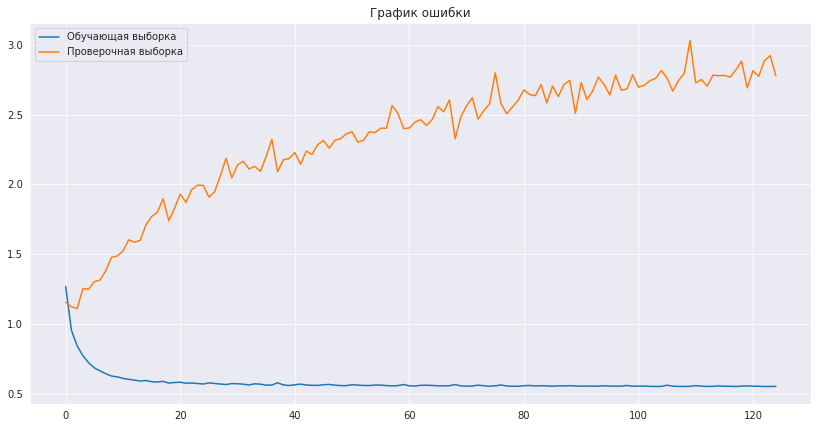

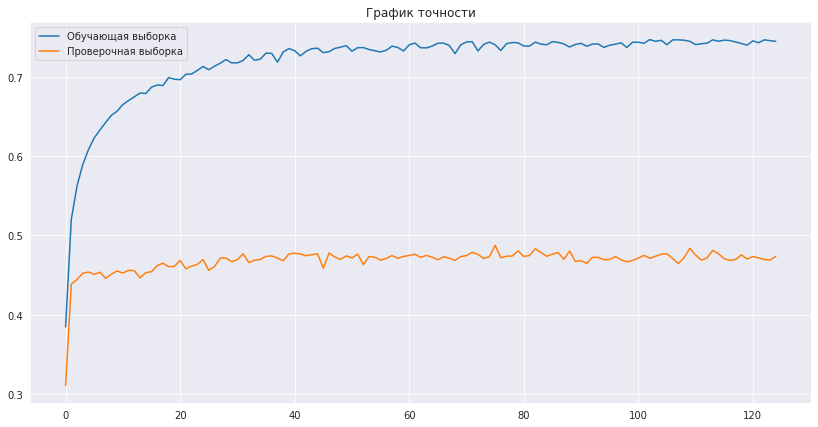

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Проверочная выборка')
plt.legend()
plt.title('График ошибки')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'], label='Обучающая выборка')
plt.plot(history.history['val_dice_coef'], label='Проверочная выборка')
plt.legend()
plt.title('График точности')
plt.show()

# 10 Проверка работы нейросети

In [ ]:
# Функция, выводящая точность распознавания каждой категории отдельно
def recognizeSet(tagI, pred, tags, length, value):
  total=0

  for j in range(6): # общее количество тегов
    correct=0
    for i in range(len(tagI)): # проходимся по каждому списку списка тегов
      for k in range(length): # проходимся по каждому тегу
        if tagI[i][k][j]==(pred[i][k][j]>value).astype(int): # если соответствующие индексы совпадают, значит сеть распознала верно
          correct+=1
    print("Сеть распознала категорию '{}' на {}%".format(tags[j],round(100*correct/(len(tagI)*length), 2)))
    total += 100 * correct / (len(tagI)*length)
  print("Cредняя точность {}%".format(total/6))

In [ ]:
#model_b_UNET = create_unet(input_shape=(xLen, embeddingSize))
#model_b_UNET.load_weights('/content/drive/My Drive/Базы/model_segment_text.h5')

In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
tok_agreemTest = tokenizer.texts_to_sequences(wordsToTest) # Обучающие тесты в индексы

print("Взглянем на фрагмент тестового текста:")
print("В виде оригинального текста:              ", wordsToTest[4][:20])
print("Он же в виде последовательности индексов: ", tok_agreemTest[4][:20], '\n')

Взглянем на фрагмент тестового текста:
В виде оригинального текста:               ['трудовой', 'контракт', 'с', 'генеральный', 'директор', 'товарищество', 'с', 'ограниченный', 'ответственность', 'г', 'г', '1', 'общий', 'положение', '1', '1', 'настоящий', 'контракт', 'заключить', 'между']
Он же в виде последовательности индексов:  [173, 434, 9, 697, 488, 976, 9, 1500, 75, 56, 56, 5, 153, 181, 5, 5, 7, 434, 102, 185] 



In [ ]:
xDataTest, yDataTest = get01XSamples(tok_agreemTest,tags_index) # Распознаем теги и создаем список с ними, с индексами
decoded_text = reverseIndex(clean_voc, xDataTest) # Для создания списков с embedding-ами сначала преобразуем список индексов обратно в слова

In [ ]:
print('Длина xDataTest:', len(xDataTest))
print('Длина yDataTest:', len(yDataTest))

print('Посмотрим на исходный набор слов: ', wordsToTest[0][50:80])
print('Посмотрим на декодированный текст:', decoded_text[50:80])
print('Посмотрим на часть из xDataTest:     ', xDataTest[50:80])
print('Посмотрим на часть из yDataTest:     ', yDataTest[50:80])

Длина xDataTest: 25903
Длина yDataTest: 25903
Посмотрим на исходный набор слов:  ['договариваться', 'сторона', 'признавать', 'что', 'они', 'право', 'и', 'обязанность', 'регулироваться', 'настоящий', 'контракт', 'а', 'также', 'действовать', 'коллективный', 'соглашение', 'договор', 'правило', 'трудовой', 'распорядок', 'общество', 'и', 'норма', 'действовать', 'законодательство', 'россия', 'работник', 'и', 'работодатель', 'договориться']
Посмотрим на декодированный текст: ['сторона', 'признавать', 'что', 'они', 'право', 'и', 'обязанность', 'регулироваться', 'настоящий', 'контракт', 'а', 'также', 'действовать', 'коллективный', 'соглашение', 'договор', 'правило', 'трудовой', 'распорядок', 'общество', 'и', 'норма', 'действовать', 'законодательство', 'россия', 'работник', 'и', 'работодатель', 'договориться', 'что']
Посмотрим на часть из xDataTest:      [8, 1802, 120, 33, 21, 3, 87, 1340, 7, 434, 44, 82, 34, 830, 107, 2, 258, 173, 958, 252, 3, 528, 34, 69, 875, 113, 3, 262, 1038, 120]
Посмотрим

In [ ]:
xLen = 256 # Длина окна
step = 30 # Шаг
embeddingSize = 300 # Количество измерений для векторного пространства

# Генерируем наборы с заданными параметрами окна
xTest = getSetFromIndexes(decoded_text, xLen, step) # Последовательность из xLen слов
yTest = getSetFromIndexes(yDataTest, xLen, step) # Последовательность из xLen-тегов

In [ ]:
print('Длинна xTest:', len(xTest))
print('Длинна yTest:', len(yTest))
print('Длинна примера из xTest:',len(xTest[0]))
print('Длинна примера из yTrain:',len(yTest[0]), '\n')
print('Пример xTest', xTest[0])
print('Пример yTest', yTest[0], '\n')

print('Первый пример xTest:', xTest[0][step-5:step+5])
print('Второй пример xTest:', xTest[1][:10])

Длинна xTest: 855
Длинна yTest: 855
Длинна примера из xTest: 256
Длинна примера из yTrain: 256 

Пример xTest ['трудовой', 'контракт', 'по', 'нанять', 'и', 'оплата', 'труд', 'главное', 'бухгалтер', 'г', 'г', '1', 'общий', 'положение', 'настоящий', 'контракт', 'заключить', 'между', 'в', 'лицо', 'директор', 'генеральный', 'директор', 'именовать', 'в', 'дальнейший', 'работодатель', 'с', 'один', 'сторона', 'и', 'гражданин', 'кой', 'россия', 'именовать', 'в', 'дальнейший', 'работник', 'настоящий', 'контракт', 'регулировать', 'трудовой', 'и', 'иной', 'отношение', 'между', 'работник', 'и', 'работодатель', 'договариваться', 'сторона', 'признавать', 'что', 'они', 'право', 'и', 'обязанность', 'регулироваться', 'настоящий', 'контракт', 'а', 'также', 'действовать', 'коллективный', 'соглашение', 'договор', 'правило', 'трудовой', 'распорядок', 'общество', 'и', 'норма', 'действовать', 'законодательство', 'россия', 'работник', 'и', 'работодатель', 'договориться', 'что', 'быть', 'добросовестно', 'выпол

In [ ]:
# Передаем в word2vec списки списков слов для обучения
# size = embeddingSize - размер эмбеддинга
# window = 10 - расстояние между текущим и прогнозируемым словом в предложении
# min_count = 1 - игнорирование всех слов с частотой, меньше, чем 1
# workers = 10 - число потоков обучения эмбеддинга
# iter = 10 - число эпох обучения эмбеддинга

modelGENSIM = word2vec.Word2Vec(xTest, size = embeddingSize, window = 10, min_count = 1, workers = 10, iter = 10)

In [ ]:
xTestGENSIM, yTestGENSIM = getSets(modelGENSIM, xTest, yTest)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
print('Размерность полученного xTrain:', xTestGENSIM.shape)
print('Размерность полученного yTrain:', yTestGENSIM.shape)

Размерность полученного xTrain: (855, 256, 300)
Размерность полученного yTrain: (855, 256, 6)


In [ ]:
tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']
# s1 Условия
# s2 Запреты
# s3 Стоимость, всё про цены и деньги
# s4 Всё про сроки
# s5 Неустойка
# s6 Всё про адреса и геолокации

In [ ]:
pred = model_b_UNET3.predict(xTestGENSIM) # сделаем предсказание

In [ ]:
recognizeSet(yTestGENSIM, pred, tags, xLen, 0.9)

Сеть распознала категорию 'S1' на 40.34%
Сеть распознала категорию 'S2' на 97.96%
Сеть распознала категорию 'S3' на 54.15%
Сеть распознала категорию 'S4' на 64.14%
Сеть распознала категорию 'S5' на 93.31%
Сеть распознала категорию 'S6' на 85.77%
Cредняя точность 72.61025828460039%


# 11 Результаты

Нейронная сеть после обучения обеспечила достижение значения средней точности 72 % и значение метрики 0,47.

Эксперименты с внесением изменений в гиперпараметры (изменение количества блоков UNet, функций актевации) и параметры обучения (размера окна и шага, количества эпох) не оказали значительного влияния.

# 12 Выводы

Подготовлена свёрточная нейронная сеть на базе U-Net, предназначенная для сегментации текста.

Обученная нейронная сеть обеспечивает решение поставленной задачи в полной мере:
- точность составляет 72 %;
- значение метрики составляет 0,47.